# 1. Preamble

In [52]:
import pandas
import math
import networkx as nx
import networkx.algorithms
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import matplotlib.pyplot as plt

# 2. Data Import and Exploration

## 2.1 First Dataset ( Company and Directors )

In [53]:
company_director_raw = pandas.read_csv('/content/company_directorships.csv')
company_director_raw.head(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
0,1ST SOURCE CORP,34782,ALLISON N. EGIDI,f,2011-03-14,2017-03-14
1,1ST SOURCE CORP,34782,ANDREA G. SHORT,f,2023-03-10,2025-03-14
2,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY III,t,2008-03-14,2025-03-14
3,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY IV,f,2011-03-14,2025-03-14
4,1ST SOURCE CORP,34782,CRAIG A. KAPSON,f,2008-03-14,2017-03-14


In [54]:
company_director_raw.info()
missing_values = company_director_raw.isnull().sum()
print("Missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13347 entries, 0 to 13346
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company_name         13347 non-null  object
 1   cikcode              13347 non-null  int64 
 2   director_name        13347 non-null  object
 3   software_background  13347 non-null  object
 4   start_date           13347 non-null  object
 5   end_date             13347 non-null  object
dtypes: int64(1), object(5)
memory usage: 625.8+ KB
Missing values in each column:
 company_name           0
cikcode                0
director_name          0
software_background    0
start_date             0
end_date               0
dtype: int64


In [55]:
company_director_raw['company_name'] = company_director_raw.company_name.str.upper().str.strip()
company_director_raw.groupby('company_name').director_name.nunique().sort_values(ascending=False)

,director_name
company_name,
INVESCO ADVANTAGE MUNICIPAL INCOME TRUST II,55
INVESCO MUNICIPAL OPPORTUNITY TRUST,55
INVESCO TRUST FOR INVESTMENT GRADE NEW YORK MUNICIPALS,55
INVESCO PENNSYLVANIA VALUE MUNICIPAL INCOME TRUST,55
INVESCO MUNICIPAL TRUST,55
...,...
"LEE PHARMACEUTICALS, INC.",3
KONINKLIJKE PHILIPS NV,3
CONNECTICUT LIGHT & POWER CO,2


In [56]:
company_director_raw['NAME'] = company_director_raw.director_name.str.upper().str.strip()
company_director_raw.groupby('director_name').company_name.nunique().sort_values(ascending=False)

,company_name
director_name,
ALBERT R. DOWDEN,14
DOUGLAS SHARP,13
ROBERT C. TROCCOLI,13
DAVID C. ARCH,13
PREMA MATHAI-DAVIS,13
...,...
HOWARD A. BRECHER,1
HOWARD A. SEVERSON,1
"HOWARD B. SILVERMAN, PH.D.",1


In [57]:
company_director_raw.groupby('software_background').count()

,company_name,cikcode,director_name,start_date,end_date,NAME
software_background,,,,,,
f,11021,11021,11021,11021,11021,11021
t,2326,2326,2326,2326,2326,2326


## 2.2 Second Dataset ( Director Details )

In [58]:
director_details_raw = pandas.read_csv('/content/director-details.csv')
director_details_raw.sample(5)

,id,url,name,age,role,compensation,source_excerpt,created_at,gender
799,790,https://www.sec.gov/Archives/edgar/data/16918/...,William Giles,64,Independent Director,253210,Mr. Giles served as Chief Financial Officer an...,2025-05-16 16:30:08.86457,male
2922,2913,https://www.sec.gov/Archives/edgar/data/75677/...,Robert C. Lyons,61,Independent Director,274981,Robert C. Lyons is 61 years old and has served...,2025-05-16 16:33:12.157689,male
1260,1249,https://www.sec.gov/Archives/edgar/data/30305/...,Shirley G. Drazba,67,Lead Independent Director,240000,Shirley G. Drazba\nLEAD INDEPENDENT DIRECTOR\n...,2025-05-16 16:30:51.323468,female
5151,5144,https://www.sec.gov/Archives/edgar/data/707549...,Jyoti K. Mehra,48,Director,360119,Jyoti K. Mehra has served as the Executive Vic...,2025-05-16 16:36:33.025093,female
4328,4314,https://www.sec.gov/Archives/edgar/data/217346...,Lionel L. Nowell III,70,"Director, Chair, Audit Committee",332500,"Mr. Nowell, 70, is the retired Senior Vice Pre...",2025-05-16 16:35:12.024785,male


In [59]:
director_details_raw.info()
missing_values = director_details_raw.isnull().sum()
print("Missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5910 non-null   int64 
 1   url             5910 non-null   object
 2   name            5910 non-null   object
 3   age             5910 non-null   int64 
 4   role            5909 non-null   object
 5   compensation    5910 non-null   int64 
 6   source_excerpt  5910 non-null   object
 7   created_at      5910 non-null   object
 8   gender          5889 non-null   object
dtypes: int64(3), object(6)
memory usage: 415.7+ KB
Missing values in each column:
 id                 0
url                0
name               0
age                0
role               1
compensation       0
source_excerpt     0
created_at         0
gender            21
dtype: int64


In [60]:
director_details_raw['NAME'] = director_details_raw.name.str.upper().str.strip()
director_details_raw.name.nunique()

5421

In [61]:
director_details_raw['gender'].value_counts(dropna=False)


,count
gender,
male,4176
female,1711
NaN,21
unknown,2


# 3. Data Cleaning and Preprocessing

In [62]:
company_director = company_director_raw.drop( ['cikcode'], axis = 1)
company_director.software_background = company_director.software_background.map(lambda x: x == 't')
company_director['service_years'] = round((pandas.to_datetime(company_director.end_date) - pandas.to_datetime(company_director.start_date)).dt.days / 365, 2)
company_director.sample(5)

,company_name,director_name,software_background,start_date,end_date,NAME,service_years
302,AGEAGLE AERIAL SYSTEMS INC.,THOMAS GARDNER,True,2018-11-29,2024-04-26,THOMAS GARDNER,5.41
2362,CINTAS CORP,JAMES J. JOHNSON,False,2009-09-04,2019-09-17,JAMES J. JOHNSON,10.04
6246,INTERNATIONAL PAPER CO /NEW/,"JOHN L. TOWNSEND, III",False,2014-04-10,2017-04-06,"JOHN L. TOWNSEND, III",2.99
6399,INVESCO CALIFORNIA VALUE MUNICIPAL INCOME TRUST,DANIEL S. VANDIVORT,False,2021-06-22,2024-07-02,DANIEL S. VANDIVORT,3.03
12483,UNUM GROUP,RICHARD P. MCKENNEY,True,2015-04-09,2023-04-13,RICHARD P. MCKENNEY,8.02


In [105]:
def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

def role_importance(role):
    if pandas.isna(role):
        return 0
    role = role.lower()
    if 'chief executive officer' in role or 'ceo' in role:
        return 20
    elif 'chair' in role:
        return 10
    elif 'director' in role:
        return 5
    else:
        return 0

In [106]:
director_details_raw['role_score'] = director_details_raw['role'].map(role_importance)
director_details = pandas.DataFrame({
    'age': director_details_raw.groupby('NAME').age.max(),
    'compensation': director_details_raw.groupby('NAME').compensation.sum(),
    'gender': director_details_raw.groupby('NAME').gender.agg(most_common),
    'role_score': director_details_raw.groupby('NAME').role_score.max(),
})
director_details['log_compensation'] = (1 + director_details.compensation).map(math.log10)
director_details

,age,compensation,gender,role_score,log_compensation
NAME,,,,,
A. CATHERINE NGO,64,1006154,female,5,6.002665
A. EUGENE WASHINGTON,70,324871,male,5,5.511712
A. F. PETROCELLI,80,47000,male,20,4.672107
A. FARAZ ABBASI,52,113631,male,5,5.055501
A. LARRY CHAPMAN,78,259500,male,5,5.414139
...,...,...,...,...,...
ZACKARY IRANI,58,360103,male,20,5.556428
ZAHID AFZAL,62,0,male,5,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5,5.278664


In [107]:
influence_factors = pandas.merge(director_details, company_director[['company_name', 'NAME', 'service_years']], on='NAME', how='outer').fillna(0)
influence_factors['weight'] = 1 / (
    influence_factors['log_compensation'].clip(lower=1) *
    influence_factors['role_score'].clip(lower=1) *
    (influence_factors['service_years']/3).clip(lower=1)
)

In [111]:
influence_factors.sample(5)

,NAME,age,compensation,gender,role_score,log_compensation,company_name,service_years,weight
2658,DEBORAH H. EVERHART,0.0,0.0,0,0.0,0.000000,"COCA-COLA CONSOLIDATED, INC.",6.02,0.498339
99,AHMET C. DORDUNCU,71.0,293926.0,male,20.0,5.468239,INTERNATIONAL PAPER CO /NEW/,10.98,0.002498
8133,MARK A. EMMERT,72.0,299982.0,male,5.0,5.477097,WEYERHAEUSER CO,9.99,0.010966
6588,JORGE L. TITINGER,0.0,0.0,0,0.0,0.000000,COHU INC,1.99,1.000000
12697,TONY A. JENSEN,0.0,0.0,0,0.0,0.000000,ROYAL GOLD INC,5.99,0.500835


## 3.2 Checking Processed Result

In [112]:
director_details.gender.value_counts(dropna=False)

,count
gender,
male,3850
female,1550
None,19
unknown,2


In [31]:
directorship_counts = company_director.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

,company_name
director_name,
MICHAEL LUETKEMEYER,1
MICHAEL L. KUBACKI,1
MICHAEL L. KUTA,1
MICHAEL L. LARUSSO,1
MICHAEL L. MILLER,1
...,...
CHRISTOPHER L. WILSON,13
LARRY SOLL,13
ELI JONES,13


<Axes: xlabel='company_name'>

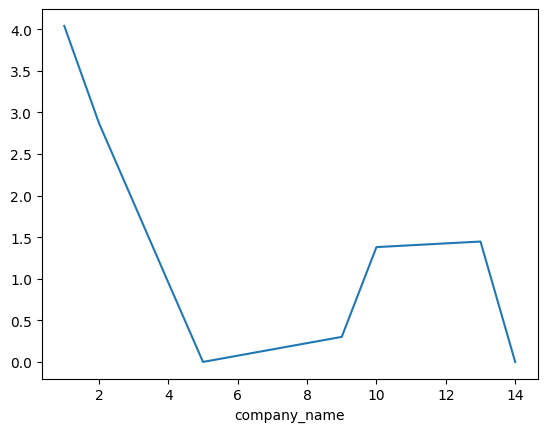

In [32]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

# 4. Network Analysis

In [130]:
graph = nx.Graph()
people = []
companies = []
for company_name, director_name, weight in zip(influence_factors.company_name, influence_factors.NAME, influence_factors.weight):
    graph.add_edge(company_name, director_name, weight=weight)
    people.append(director_name)
    companies.append(company_name)

In [131]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [132]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(nx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(nx.algorithms.degree_centrality(biggest_connected_graph)),
    'closeness_weighted': pandas.Series(nx.closeness_centrality(biggest_connected_graph, distance='weight'))
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 46.9 ms, sys: 2.01 ms, total: 48.9 ms
Wall time: 49.1 ms


In [133]:
people_df = centrality[centrality.is_person].merge(director_details, left_index=True, right_index=True)

In [136]:
people_df.sort_values('closeness_weighted', ascending=False)

,eigen,degree,closeness_weighted,is_person,age,compensation,gender,role_score,log_compensation
DAVID BORLAND,0.085749,0.015152,0.808475,True,77,217500,male,5,5.337461
JOHN B. WOOD,0.085749,0.015152,0.807235,True,61,0,male,20,0.000000
"ROBERT W. LEASURE, JR.",0.085749,0.015152,0.802358,True,65,1659378,male,20,6.219946
R. MATTHEW NEFF,0.085749,0.015152,0.800169,True,69,146775,male,10,5.166655
BONNIE CARROLL,0.085749,0.015152,0.796115,True,67,216250,female,5,5.334958
"JOHN E. SAGARTZ, DVM, PH.D., DACVP",0.085749,0.015152,0.794316,True,59,474750,male,5,5.676466
FREDRICK D. SCHAUFELD,0.085749,0.015152,0.794131,True,65,217500,male,5,5.337461
BRAD JACOBS,0.085749,0.015152,0.788552,True,67,215000,male,5,5.332440
DERRICK D. DOCKERY,0.085749,0.015152,0.788507,True,44,210000,male,5,5.322221
JOHN W. MALUDA,0.085749,0.015152,0.788392,True,71,197500,male,5,5.295569


In [ ]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

In [ ]:

robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [ ]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

In [ ]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [ ]:
people_df.loc['ELIZABETH KRENTZMAN']